In [3]:
import numpy as np
import math
from scipy.stats import random_correlation
import matplotlib.pyplot as plt
import timeit
from scipy.stats import norm
np.random.seed(0)

In [4]:
T = 1 # time length
N = 252 # number of steps
K = 90 # strike price
r = 0 # expected return rate = risk-free rate in risk-neutral world
M = 2 # number of stocks
S_0 = np.full((M), 100) # initial stock price
# create a random volatilities and a random correlation matrix
sigma = [0.4, 0.3] # np.random.uniform(0.15, 0.65, M) # volatility
# generate a random correlation matrix
cor = np.array([[1,0.5], [0.5,1]]) # random_correlation.rvs(np.random.dirichlet(np.ones(M)) * M) # correlation matrix
print("sigma: \n", sigma)
print("correlation matrix: \n", cor)

sigma: 
 [0.4, 0.3]
correlation matrix: 
 [[1.  0.5]
 [0.5 1. ]]


## 1. Simulate Correlated Stock Prices using Geometric Brownian Motion

In [5]:
def simulate_corrolated_stocks(S_0, T, N, M, sigma, cor, r):
    # S_0: array of stock prices at time 0
    # T: time length (positive integer)
    # N: number of steps (positive integer)
    # M: number of stocks
    # sigma: volatilities
    # cor: correlation matrix
    # r: risk-free interest rate
    mean = np.zeros(M)
    z = np.random.multivariate_normal(mean, cor, N)
    z = np.concatenate((np.zeros((1, M)), z), axis = 0)
    B = np.sqrt(T / N) * np.cumsum(z, 0)
    S = np.zeros(np.shape(B))
    t = np.linspace(0, T, N + 1)
    for x in range(len(B[0])):
        S[:, x] = S_0[x] * np.exp((r - 0.5 * sigma[x] ** 2) * t[x] + sigma[x] * B[:, x])
    return S

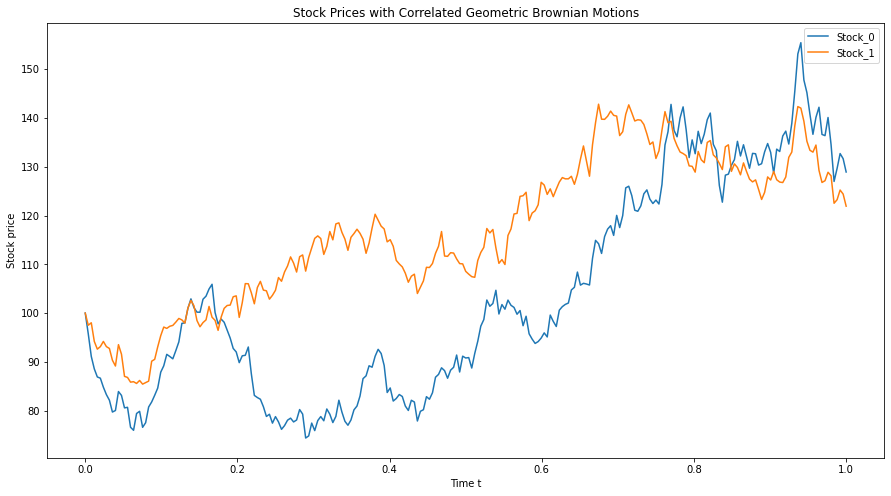

In [6]:
S_t = simulate_corrolated_stocks(S_0, T, N, M, sigma, cor, r)
t = np.linspace(0, 1, N + 1)
plt.figure(figsize=(15,8))
plt.plot(t, S_t)
plt.ylabel("Stock price")
plt.xlabel("Time t")
plt.title("Stock Prices with Correlated Geometric Brownian Motions")
if (M < 7):
    plt.legend(["Stock_" + str(x) for x in range(M)])

## 2. Monte Carlo Simulation for Exchange Option Pricing

In [7]:
def MCS_exchange_option_pricing(S_0, r, T, sigma, cor, number_of_trails = 10000):
    '''
    S_0: stock price at time 0, give up asset with price S_0[0] and receive asset with price S_0[1] at time T.
    r: risk-free rate
    T: maturity date
    sigma: volatilities
    cor: correlation matrix
    number_of_trails: number of trails of MCS
    '''
    payoffs = np.zeros(number_of_trails)
    for x in range(number_of_trails):
        S_t = simulate_corrolated_stocks(S_0, T, N, 2, sigma, cor, r)
#         print(S_t)
#         print(S_t[-1, 1])
#         print(S_t[-1, 0])
        # calculate payoffs
        payoffs[x] = np.maximum(0, np.exp(-1 * r * T) * (S_t[-1, 1] - S_t[-1, 0]))
    return np.mean(payoffs)

In [10]:
a = MCS_exchange_option_pricing([100, 100], 0, 1, [0.3, 0.6], [[1,0.5],[0.5,1]], 10000)
a_r = MCS_exchange_option_pricing([100, 100], 0.5, 1, [0.3, 0.6], [[1,0.5],[0.5,1]], 10000)
# b = MCS_exchange_option_pricing([100, 100], 0, 1, [0.6, 0.3], [[1,0.5],[0.5,1]], 10000)
# c = MCS_exchange_option_pricing(S_0, r, T, sigma, cor, 10000)
print(a)
print(a_r)
# print(c)

31.047983035498888
18.436888334063397


In [56]:
number_of_simulations = np.array([100, 300, 600, 1000, 5000,  15555,  26111, 6666,  47222,  57777,  68333,  78888,  89444, 100000])

exchange option price:  13.347712230807417
Time:  104.84117619999961


Text(0.5, 1.0, 'Price convergence of Monte Carlo Simulation')

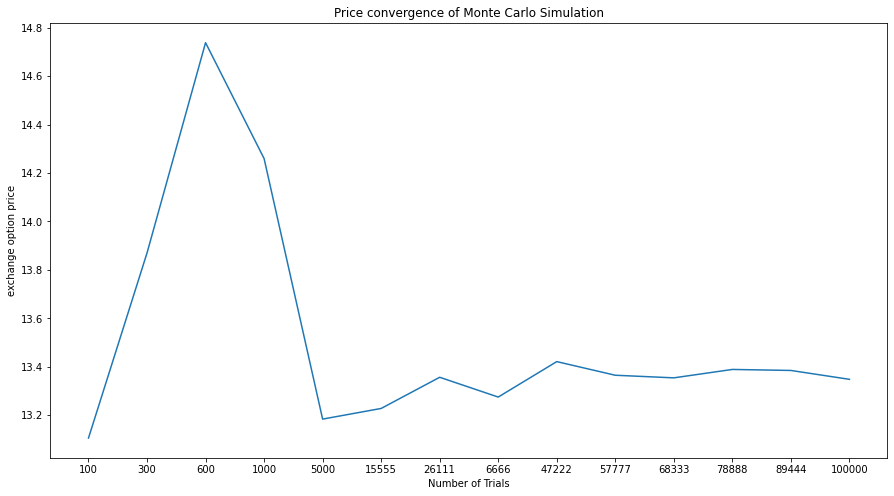

In [57]:
exchange_prices = np.zeros(len(number_of_simulations))
start = timeit.default_timer()
for x in range(len(number_of_simulations)):
    np.random.seed(1)
    exchange_prices[x] = MCS_exchange_option_pricing(S_0, r, T, sigma, cor, number_of_simulations[x])
stop = timeit.default_timer()
print("exchange option price: ", exchange_prices[-1])
print("Time: ", stop - start) 
plt.figure(figsize=(15,8))
plt.plot([str(x) for x in number_of_simulations], exchange_prices)
plt.ylabel("exchange option price")
plt.xlabel("Number of Trials")
plt.title("Price convergence of Monte Carlo Simulation")

## 3. Exchange Option Pricing using Margrabe's formula

"European option to give up an asset worth $S_1$ at time $T$ and receive in
return an asset worth $S_2$"

#### Margrabe's formula
$C = S_2 e^{-q_1 T} N(d_1) - S_1 e^{-q_1 T} N(d_2)$

$d_1 = \frac{ln(\frac{S_2}{S_1}) + (q_1 - q_2 + \sigma^2/2)T}{\sigma \sqrt{T}}, \ d_2 = d_1 - \sigma \sqrt{T}$

$\\\sigma = \sqrt{\sigma_1^2 + \sigma_2^2 - 2\rho\sigma_1\sigma_2}$



In [58]:
def Margrabe_option_pricing(S_0, q, T, sigma, cor):
    '''
    S_0: stock price at time 0, give up asset with price S_0[0] and receive asset with price S_0[1] at time T.
    T: maturity date
    sigma: volatilities
    cor: correlation (not matrix)
    '''
    sd = math.sqrt(sigma[0] ** 2 + sigma[1] ** 2 - 2 * cor * sigma[0] * sigma[1])
    d1 = (math.log(S_0[1] / S_0[0]) + (q[0] - q[1] + sd**2 / 2) * T) / (sd * math.sqrt(T))
    d2 = d1 - sd * math.sqrt(T)
    return S_0[1] * math.exp(-q[1] * T) * norm.cdf(d1) - S_0[0] * math.exp(-q[0] * T) * norm.cdf(d2)

In [70]:
print(S_0)
print(T)
print(sigma)
print(cor[0,1])
d = Margrabe_option_pricing([100, 100], [0, 0], 1, [0.3, 0.6], 0.5)
e = Margrabe_option_pricing([100, 100], [0, 0], 1, [0.6, 0.3], 0.5)
f = Margrabe_option_pricing(S_0, [0, 0], T, sigma, cor[0, 1])
print(d)
print(e)
print(f)

[100 100]
1
[0.4, 0.3]
0.5
20.498782803576184
20.498782803576184
14.306533139477423


different from the result got from MCS.
Using Margrabe's formula, switching the volatilities does not change the result???



## 4. Monte Carlo Simulation for Basket Option Pricing

In [18]:
def MCS_basket_option_pricing(S_0, K, M, w, r, T, N, sigma, cor, number_of_trails = 10000):
    '''
    S_0: stock prices at time 0 (1-d array)
    K: strike price
    M: number of stocks in the basket
    w: weights (1-d array)
    r: risk-free rate
    T: maturity date
    sigma: volatilities (1-d array)
    cor: correlation matrix
    number_of_trails: number of trails of MCS
    '''
    payoffs = np.zeros(number_of_trails)
    for x in range(number_of_trails):
        S_t = simulate_corrolated_stocks(S_0, T, N, M, sigma, cor, r)
        # calculate payoffs
        payoffs[x] = np.maximum(0, np.sum(w * S_t[-1, :]) - K)
    return np.exp(-1 * r * T) * np.mean(payoffs)

In [71]:
MCS_basket_option_pricing([100, 100], 90, 2, [0.2, 0.8], 0, 1, 252, [0.3, 0.6], [[1,0.4], [0.4,1]], 10000)

37.46055455631714

basket option price:  36.50471874990463
Time:  214.17032386100004


Text(0.5, 1.0, 'Price convergence of Monte Carlo Simulation')

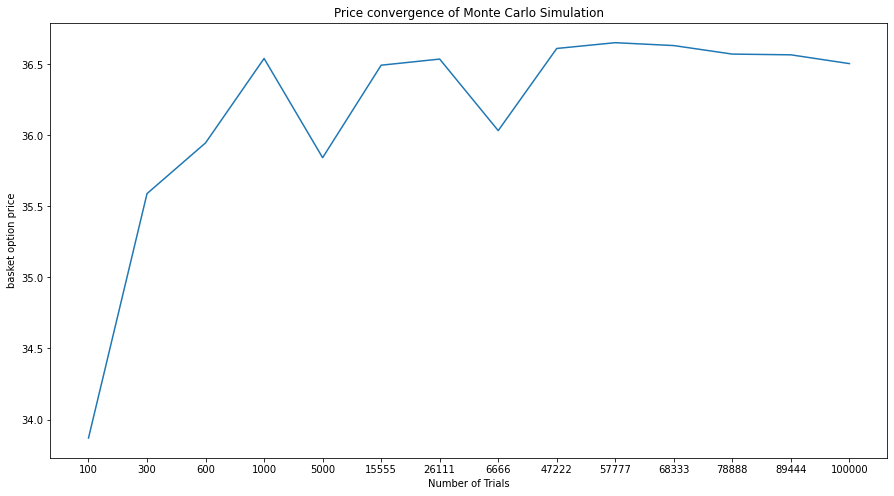

In [19]:
basket_prices = np.zeros(len(number_of_simulations))
start = timeit.default_timer()
for x in range(len(number_of_simulations)):
    np.random.seed(2)
    basket_prices[x] = MCS_basket_option_pricing([100, 100], 90, 2, [0.2, 0.8], 0, 1, 252, [0.3, 0.6], [[1,0.4], [0.4,1]], number_of_simulations[x])
stop = timeit.default_timer()
print("basket option price: ", basket_prices[-1])
print("Time: ", stop - start) 
plt.figure(figsize=(15,8))
plt.plot([str(x) for x in number_of_simulations], basket_prices)
plt.ylabel("basket option price")
plt.xlabel("Number of Trials")
plt.title("Price convergence of Monte Carlo Simulation")